In [1]:
import torch 
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, Linear, ReLU, Sequential
import cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import pandas as pd
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt
# from torchvision.models import resnet18
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [55]:
# DATA_PATH = "/kaggle/input/unibuc-ml-202325/"
DATA_PATH = "../data/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.0001,
    'num_classes': 96,
    'dropout': 0.5,
    'trained_epochs': 0,
    'patience': 3,
    'image_size': (64, 64),
    'best': 0,
    'model_path': '../models/model_deepnet.pth',
    'model_name': 'DCNN',
    'augmentation': True,
    'criterion': CrossEntropyLoss(),
}

In [43]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = pd.read_csv(csv_file)
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return (image, label)    

In [44]:
class TestImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.df.iloc[index, 0]
        img_path = os.path.join(self.img_dir, img_id)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return (image, img_id)


In [56]:
# for more image transforms  https://pytorch.org/vision/stable/transforms.html

# transforms

img_size = hyperparameters['image_size']

original_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

horizontal_flip_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

vertical_flip_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

gaussian_blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.GaussianBlur(5, sigma=(0.1, 1.0)),
    transforms.ToTensor()
])

translation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

noise_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),
    transforms.ToPILImage(),
    transforms.ToTensor()
])

rotation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

color_jitter_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor()
])

resized_crop_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

extend_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [57]:
# datasets

original_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=original_transform)
horizontal_flip_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=horizontal_flip_transform)
rotation_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=rotation_transform)
color_jitter_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=color_jitter_transform)
resized_crop_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=resized_crop_transform)
vertical_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=vertical_flip_transform)
gaussian_blur_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=gaussian_blur_transform)
translation_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=translation_transform)
noise_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=noise_transform)
extend_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=extend_transform)

In [58]:
train_dataset = original_dataset
if hyperparameters['augmentation'] == True:
    train_dataset = ConcatDataset([original_dataset, horizontal_flip_dataset, rotation_dataset, color_jitter_dataset, resized_crop_dataset, gaussian_blur_dataset, translation_dataset])
val_dataset = CustomImageDataset(img_dir=DATA_PATH + "val_images", csv_file=DATA_PATH + "val.csv", transform=original_transform)
test_dataset = TestImageDataset(img_dir=DATA_PATH + "test_images", csv_file=DATA_PATH + "test.csv", transform=original_transform)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

In [59]:
class DeepNet(nn.Module):
    def __init__(self, num_classes=96):
        super(DeepNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch, you can also use x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [60]:
def save_model(model, optimizer, path):
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, path)

def load_model(model, optimizer, path):
    state = torch.load(path)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    return model, optimizer

In [61]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
loss_list = []
conf_matrix = np.zeros((96, 96))

In [62]:
def train_model(train_loader, val_loader, model, optimizer, num_epochs, hyperparameters):
    global accuracy_list, precision_list, recall_list, loss_list, conf_matrix
    model = model.to(device)
    criterion = hyperparameters['criterion']
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau  (optimizer, mode='min', factor=0.1, patience=hyperparameters['patience'])
    trained_epochs = hyperparameters['trained_epochs']
    for epoch in range(num_epochs):
        print(f"Epoch {trained_epochs + epoch + 1} started... ")
        # set the model to train mode
        # enable dropout, batch normalization etc.
        model.train()
        for images, labels in tqdm(train_loader):
            # loads the images to cuda if available
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # compute the loss

            optimizer.zero_grad() # reset the gradients because they accumulate by default
            loss.backward() # compute the gradients in the backward pass
            optimizer.step() # update the parameters based on the gradients computed in the backward pass
        print("Validating data...")
        # set the model to evaluation mode
        # disable dropout, batch normalization etc.
        model.eval()
        with torch.no_grad():  # disable gradient calculation and backpropagation
            val_loss = 0
            correct = 0
            total = 0
            curr_predictions = []
            curr_labels = []
            curr_conf_matrix = np.zeros((96, 96))
            for images, labels in tqdm(val_loader):
                # loads the images to cuda if available
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                # torch.max returns a tuple (values, indices) where indices is the index of the maximum value of a tensor along a dimension
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()
                curr_predictions.extend(predicted.cpu().numpy())
                curr_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader)
            scheduler.step(val_loss) # step the scheduler based on the validation loss

            print('Epoch [{}/{}], Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
                    .format(trained_epochs + epoch + 1, trained_epochs + num_epochs, 100 * correct / total, val_loss))
            
            hyperparameters['trained_epochs'] += 1
            
            accuracy_list.append(100 * correct / total)
            loss_list.append(val_loss)

            precision_list.append(precision_score(curr_labels, curr_predictions, average='macro'))
            recall_list.append(recall_score(curr_labels, curr_predictions, average='macro'))
            f1_list.append(f1_score(curr_labels, curr_predictions, average='macro'))
            curr_conf_matrix = confusion_matrix(curr_labels, curr_predictions)
    
            if hyperparameters['best'] < correct / total:
                hyperparameters['best'] = correct / total
                conf_matrix = np.copy(curr_conf_matrix)
                save_model(model, optimizer, hyperparameters['model_path'])
                print("Model saved!")
    return model, optimizer

In [63]:
def test_model(model, test_loader):
    model.eval()
    predicted_labels = []
    image_ids = []
    with torch.no_grad(): # to disable gradient calculation and backpropagation
        for images, ids in tqdm(test_loader):
            images = images.to(device)

            outputs = model(images) # forward pass

            _, predicted = torch.max(outputs.data, 1) # get the predicted class with highest probability

            predicted_labels.extend(predicted.tolist())
            image_ids.extend(ids)
    return predicted_labels, image_ids

In [64]:
model = DeepNet().to(device)
optimizer = Adam(model.parameters(), lr=hyperparameters['learning_rate'])
hyperparameters['best'] = 0
hyperparameters['trained_epochs'] = 0

In [65]:
model, optimizer = train_model(train_loader, val_loader, model, optimizer, 30, hyperparameters)

Epoch 1 started... 


100%|██████████| 1313/1313 [00:56<00:00, 23.23it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 29.22it/s]


Epoch [1/30], Validation Accuracy: 68.90%, Validation Loss: 1.0578
Model saved!
Epoch 2 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.48it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.95it/s]


Epoch [2/30], Validation Accuracy: 80.00%, Validation Loss: 0.7134
Model saved!
Epoch 3 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.75it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.85it/s]


Epoch [3/30], Validation Accuracy: 72.50%, Validation Loss: 1.1172
Epoch 4 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.53it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.30it/s]


Epoch [4/30], Validation Accuracy: 85.50%, Validation Loss: 0.5231
Model saved!
Epoch 5 started... 


100%|██████████| 1313/1313 [00:56<00:00, 23.39it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.91it/s]
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/30], Validation Accuracy: 80.30%, Validation Loss: 0.8328
Epoch 6 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.55it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.92it/s]


Epoch [6/30], Validation Accuracy: 83.20%, Validation Loss: 0.7615
Epoch 7 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.54it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.47it/s]


Epoch [7/30], Validation Accuracy: 86.20%, Validation Loss: 0.5782
Model saved!
Epoch 8 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.69it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.19it/s]


Epoch [8/30], Validation Accuracy: 86.00%, Validation Loss: 0.6095
Epoch 9 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.74it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.24it/s]


Epoch [9/30], Validation Accuracy: 90.90%, Validation Loss: 0.3396
Model saved!
Epoch 10 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.50it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.24it/s]


Epoch [10/30], Validation Accuracy: 90.80%, Validation Loss: 0.3487
Epoch 11 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.56it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.83it/s]


Epoch [11/30], Validation Accuracy: 90.80%, Validation Loss: 0.3566
Epoch 12 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.66it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.77it/s]


Epoch [12/30], Validation Accuracy: 90.60%, Validation Loss: 0.3558
Epoch 13 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.72it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.70it/s]


Epoch [13/30], Validation Accuracy: 89.90%, Validation Loss: 0.3893
Epoch 14 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.70it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.28it/s]


Epoch [14/30], Validation Accuracy: 90.90%, Validation Loss: 0.3766
Epoch 15 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.64it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.79it/s]


Epoch [15/30], Validation Accuracy: 91.10%, Validation Loss: 0.3732
Model saved!
Epoch 16 started... 


100%|██████████| 1313/1313 [00:56<00:00, 23.34it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.47it/s]


Epoch [16/30], Validation Accuracy: 91.00%, Validation Loss: 0.3644
Epoch 17 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.51it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.14it/s]


Epoch [17/30], Validation Accuracy: 91.30%, Validation Loss: 0.3703
Model saved!
Epoch 18 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.65it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.94it/s]


Epoch [18/30], Validation Accuracy: 91.40%, Validation Loss: 0.3708
Model saved!
Epoch 19 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.58it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.93it/s]


Epoch [19/30], Validation Accuracy: 91.40%, Validation Loss: 0.3742
Epoch 20 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.60it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.07it/s]


Epoch [20/30], Validation Accuracy: 91.00%, Validation Loss: 0.3675
Epoch 21 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.74it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.41it/s]


Epoch [21/30], Validation Accuracy: 90.70%, Validation Loss: 0.3675
Epoch 22 started... 


100%|██████████| 1313/1313 [00:54<00:00, 23.90it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.25it/s]


Epoch [22/30], Validation Accuracy: 91.00%, Validation Loss: 0.3610
Epoch 23 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.74it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.11it/s]


Epoch [23/30], Validation Accuracy: 90.80%, Validation Loss: 0.3675
Epoch 24 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.83it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 30.96it/s]


Epoch [24/30], Validation Accuracy: 91.30%, Validation Loss: 0.3686
Epoch 25 started... 


100%|██████████| 1313/1313 [00:55<00:00, 23.65it/s]


Validating data...


100%|██████████| 16/16 [00:00<00:00, 31.25it/s]


Epoch [25/30], Validation Accuracy: 90.90%, Validation Loss: 0.3736
Epoch 26 started... 


 38%|███▊      | 495/1313 [00:21<00:35, 23.25it/s]


KeyboardInterrupt: 

In [68]:
model, optimizer = load_model(model, optimizer, hyperparameters['model_path'])

In [69]:
predicted_labels, image_ids = test_model(model, test_loader)

100%|██████████| 79/79 [00:02<00:00, 31.66it/s]


In [70]:
df_predictions = pd.DataFrame({
    'Image': image_ids,
    'Class': predicted_labels
})

# Save the DataFrame to a CSV file
df_predictions.to_csv('../submissions/submission_deepnet.csv', index=False)

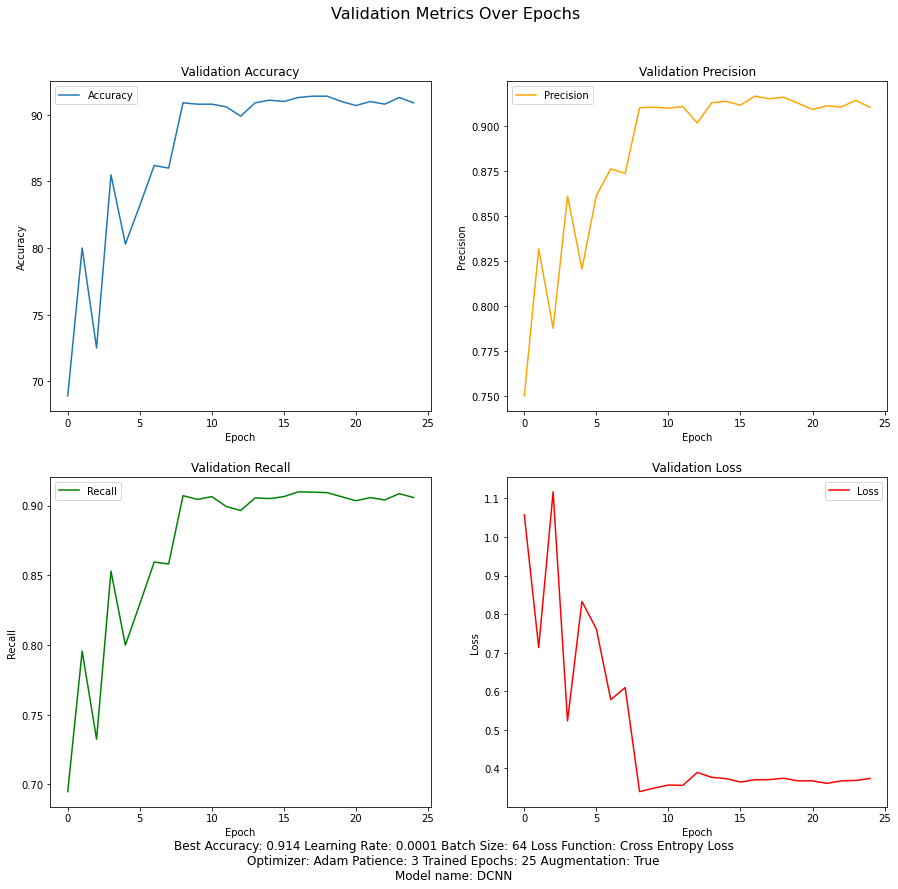

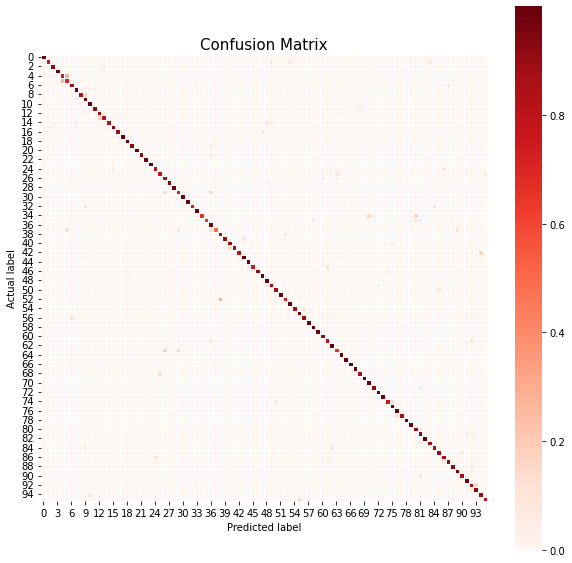

In [66]:
# plot the accuracy and loss in two different plots

# accuracy_list = np.random.randint(0, 100, size=(40))
# precision_list = np.random.randint(0, 100, size=(40))
# recall_list = np.random.randint(0, 100, size=(40))
# f1_list = np.random.randint(0, 100, size=(40))
# loss_list = np.random.randint(0, 100, size=(40))

plt.figure(figsize=(15, 13))

# Subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(accuracy_list, label='Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for precision
plt.subplot(2, 2, 2)
plt.plot(precision_list, label='Precision', color='orange')
plt.title('Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Subplot for recall
plt.subplot(2, 2, 3)
plt.plot(recall_list, label='Recall', color='green')
plt.title('Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Subplot for loss
plt.subplot(2, 2, 4)
plt.plot(loss_list, label='Loss', color='red')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Overall title
plt.suptitle('Validation Metrics Over Epochs', fontsize=16)

# fig_text = f"Best Accuracy: {hyperparameters['best']} \nLearning Rate: {hyperparameters['learning_rate']} \nBatch Size: {hyperparameters['batch_size']} \nPatience: {hyperparameters['patience']} \nTrained Epochs: {hyperparameters['trained_epochs']} \nModel name: {hyperparameters['model_name']} \nAugmentation: True"
best = hyperparameters['best']
lr = hyperparameters['learning_rate']
batch_size = hyperparameters['batch_size']
patience = hyperparameters['patience']
trained_epochs = hyperparameters['trained_epochs']
model_name = hyperparameters['model_name']
augmentation = hyperparameters['augmentation']
crit = "Cross Entropy Loss"
opt = "Adam"
img_size = hyperparameters['image_size']
fig_text = f"Best Accuracy: {best} Learning Rate: {lr} Batch Size: {batch_size} Loss Function: {crit} \nOptimizer: {opt} Patience: {patience} Trained Epochs: {trained_epochs} Augmentation: {augmentation} \nModel name: {model_name} "

plt.figtext(0.5, 0.05, fig_text, wrap=True, horizontalalignment='center', fontsize=12)

plt.subplots_adjust(top=0.9)  # Add space at the top for the overall title
plt.savefig('../plots/metrics_net_4.png')
plt.show()

# conf_matrix = np.random.randint(0, 100, size=(96, 96))

global conf_matrix
conf_matrix = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-7)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=False, linewidths=.5, square = True, cmap = 'Reds')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.savefig('../plots/confusion_matrix_net_4.png')
plt.show()

